In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import GridSearchCV,cross_validate,cross_val_score,train_test_split
from sklearn.metrics import classification_report,accuracy_score,f1_score
from xgboost import XGBClassifier
import lightgbm
import warnings
warnings.filterwarnings('ignore')

# Exploratory Data analysis

In [6]:
df=pd.read_csv('Titanic_train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [23]:
df2=pd.read_csv('Titanic_test.csv')
df2.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# missing values found in Age,Cabin,Embarked
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<Axes: >

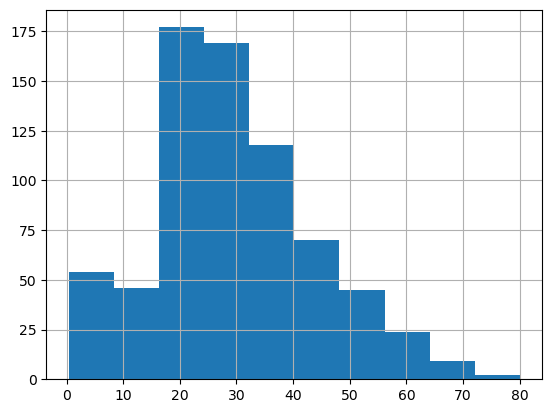

In [6]:
df.Age.hist()

In [7]:
df.Age.skew()
# Age is slightly skewed so we can impute the missing values with meadian or mean

0.38910778230082704

<Axes: xlabel='Pclass', ylabel='Fare'>

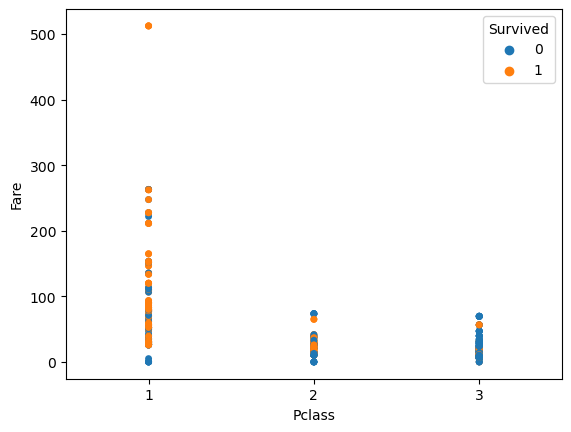

In [7]:
sns.stripplot(data=df,x='Pclass',y='Fare',hue='Survived',jitter=False)

* Fare is dependent on passenger class i.e so lets use Pclass to predict Survived instead of Fare 
* lets drop columns which are not useful to predict Survived those are PassengerId,Name,Ticket,Fare,Cabin

In [7]:
df.drop(labels=['PassengerId','Name','Ticket','Fare','Cabin'],axis=1,inplace=True)

<Axes: xlabel='Pclass'>

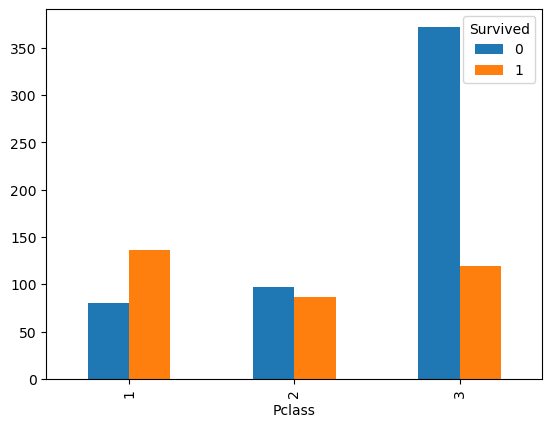

In [16]:
pd.crosstab(df.Pclass,df.Survived).plot(kind="bar")

<Axes: xlabel='Embarked'>

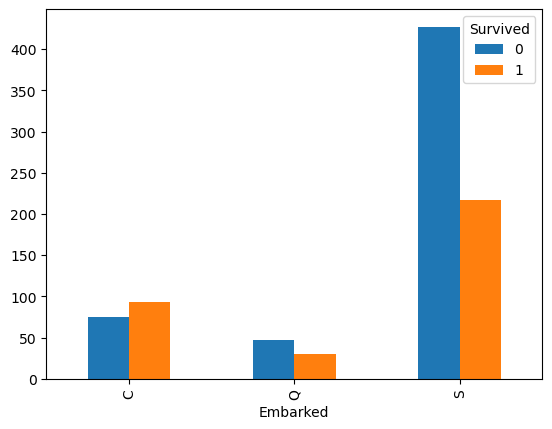

In [17]:
pd.crosstab(df.Embarked,df.Survived).plot(kind="bar")

<Axes: xlabel='Sex'>

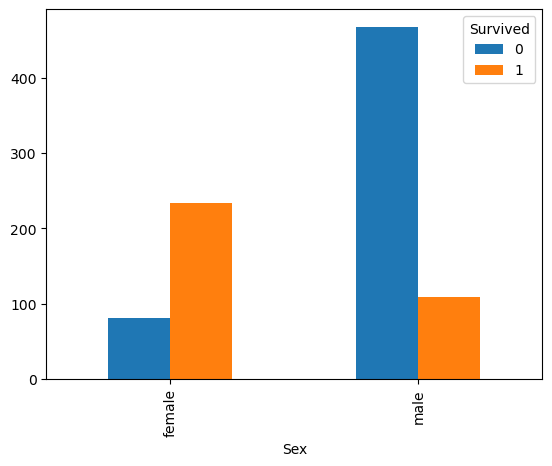

In [18]:
pd.crosstab(df.Sex,df.Survived).plot(kind="bar")

# Data Preprrocessing

In [8]:
# imputed missing values with mean(),mode()
df.Age.fillna(df.Age.median(),inplace=True)
df.Embarked.fillna(df.Embarked.mode()[0],inplace=True)

In [8]:
df.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Embarked    0
dtype: int64

In [9]:
df.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Embarked     object
dtype: object

In [9]:
# lets apply one hot encoding to Sex & Embarked
df_E=pd.get_dummies(df,dtype=int)
df_E.head()

,Survived,Pclass,Age,SibSp,Parch,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,0,1,0,0,1
1,1,1,38.0,1,0,1,0,1,0,0
2,1,3,26.0,0,0,1,0,0,0,1
3,1,1,35.0,1,0,1,0,0,0,1
4,0,3,35.0,0,0,0,1,0,0,1


In [10]:
df_E.drop('Sex_male',axis=1,inplace=True)

In [24]:
# same working on df2 which is test data
df2.drop(labels=['PassengerId','Name','Ticket','Fare','Cabin'],axis=1,inplace=True)
# imputed missing values with mean(),mode()
df2.Age.fillna(df.Age.median(),inplace=True)
df2.Embarked.fillna(df.Embarked.mode()[0],inplace=True)
# lets apply one hot encoding to Sex & Embarked
df_E2=pd.get_dummies(df2,dtype=int)
df_E2.drop('Sex_male',axis=1,inplace=True)

In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Embarked  418 non-null    object 
dtypes: float64(1), int64(3), object(2)
memory usage: 19.7+ KB


In [25]:
# the final models are going to be tested on this
X_test=df_E2
X_test.head()

,Pclass,Age,SibSp,Parch,Sex_female,Embarked_C,Embarked_Q,Embarked_S
0,3,34.5,0,0,0,0,1,0
1,3,47.0,1,0,1,0,0,1
2,2,62.0,0,0,0,0,1,0
3,3,27.0,0,0,0,0,0,1
4,3,22.0,1,1,1,0,0,1


# Building Predictive Models:

In [11]:
X=df_E.iloc[:,1:]
Y=df_E.iloc[:,0]

In [21]:
X.head()

,Pclass,Age,SibSp,Parch,Sex_female,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,0,0,0,1
1,1,38.0,1,0,1,1,0,0
2,3,26.0,0,0,1,0,0,1
3,1,35.0,1,0,1,0,0,1
4,3,35.0,0,0,0,0,0,1


In [28]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42,stratify=Y)

In [13]:
model=XGBClassifier(objective='binary:logistic',random_state=42,subsample=0.9,colsample_bytree=0.5,early_stopping_rounds=10,
                   eval_metric='aucpr')

In [14]:
# hyper parameter 'scale_pos_weight' we use here because we have unbalanced data positives{survived} are less so more penality if it predicted incorrectly
params={'max_depth':[3,4,5],'learning_rate':[0.1,0.01,0.05],'gamma':[0,0.25,1],'reg_lambda':[0,1,10],'scale_pos_weight':[1,2,3,5]}

In [15]:
# n_jobs hyper parameter tells that if the validation data's accuracy not increasing for 10 cosecutive times then stop the algorithim
# early stoping of algorithm avoids algorithm overfitting on training data
optimal_params=GridSearchCV(estimator=model,param_grid=params,scoring='roc_auc',n_jobs=10,cv=4)

In [17]:
optimal_params.fit(X_train,Y_train,eval_set=[(X_test, Y_test)])

[0]	validation_0-aucpr:0.50854
[1]	validation_0-aucpr:0.76539
[2]	validation_0-aucpr:0.74280
[3]	validation_0-aucpr:0.76325
[4]	validation_0-aucpr:0.78886
[5]	validation_0-aucpr:0.78851
[6]	validation_0-aucpr:0.79404
[7]	validation_0-aucpr:0.78040
[8]	validation_0-aucpr:0.77276
[9]	validation_0-aucpr:0.77599
[10]	validation_0-aucpr:0.77738
[11]	validation_0-aucpr:0.77840
[12]	validation_0-aucpr:0.77919
[13]	validation_0-aucpr:0.79201
[14]	validation_0-aucpr:0.79552
[15]	validation_0-aucpr:0.79983
[16]	validation_0-aucpr:0.80072
[17]	validation_0-aucpr:0.79911
[18]	validation_0-aucpr:0.79675
[19]	validation_0-aucpr:0.80161
[20]	validation_0-aucpr:0.80228
[21]	validation_0-aucpr:0.80454
[22]	validation_0-aucpr:0.80069
[23]	validation_0-aucpr:0.80053
[24]	validation_0-aucpr:0.79366
[25]	validation_0-aucpr:0.80271
[26]	validation_0-aucpr:0.80241
[27]	validation_0-aucpr:0.80289
[28]	validation_0-aucpr:0.80083
[29]	validation_0-aucpr:0.78315
[30]	validation_0-aucpr:0.78378


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, device=None,
                                     early_stopping_rounds=10,
                                     enable_categorical=False,
                                     eval_metric='aucpr', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=10,
             param_grid={'gamma': [0, 0.25, 1],
                         'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [3, 4, 5], 'reg_lambda': [0, 1, 10],
                         'scale_pos_weight': [1, 2, 3, 5]},
             scoring='roc_auc')

In [18]:
print(optimal_params.best_params_)
print(optimal_params.best_score_)

{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'reg_lambda': 10, 'scale_pos_weight': 2}
0.8595002553456382


# XGBOOST

In [13]:
final=XGBClassifier(objective='binary:logistic',random_state=42,subsample=0.9,colsample_bytree=0.5,
                    gamma= 0,learning_rate= 0.05,max_depth=5,reg_lambda=10,scale_pos_weight=2)

In [14]:
final.fit(X,Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [21]:
feature_importance=pd.Series(final.feature_importances_,index=final.feature_names_in_).sort_values(ascending=False)
feature_importance

Sex_female    0.739060
Pclass        0.107605
Embarked_S    0.036027
Age           0.030574
Embarked_Q    0.026498
Parch         0.022312
SibSp         0.020833
Embarked_C    0.017090
dtype: float32

In [19]:
print(classification_report(Y,final.predict(X)))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85       549
           1       0.74      0.82      0.78       342

    accuracy                           0.82       891
   macro avg       0.81      0.82      0.81       891
weighted avg       0.83      0.82      0.82       891



#### predictions of Titanic_test.csv

In [26]:
# model predictions on test data
Test_predict=final.predict(X_test)

# LightGBM
* hyper_parameters = https://lightgbm.readthedocs.io/en/latest/Parameters.html
* parameters_tuning = https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
* python training = https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

In [29]:
# It discretizes continuous features into histogram bins, tries to combine categorical features,
# and automatically handles missing and infinite values.
# This class handles that preprocessing, and holds that alternative representation of the input data
train_data= lightgbm.Dataset(X_train,label=Y_train)
valid_dataset=lightgbm.Dataset(X_test,label=Y_test)

In [30]:
params={'metric':'auc','n_estimators':1000,
        'scale_pos_weight':1,'early_stopping_round': 20,'max_depth':4,'objective':'binary',
       'data_sample_strategy':'goss','learning_rate':0.1,'num_leaves':30,
       'lambda_l2':1,'max_delta_step':0.25,'first_metric_only':True}

In [34]:
#model=lightgbm.LGBMClassifier()

In [35]:
#optimal_params=GridSearchCV(estimator=model,param_grid=params,n_jobs=-1,cv=5,verbose=2,scoring='roc_auc')

In [ ]:
#optimal_params.fit(train_set=train_data,params=params,valid_sets=valid_dataset)

In [71]:
model=lightgbm.train(train_set=train_data,params=params,valid_sets=valid_dataset)

[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: 0x00000299C0E960D0>
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 8
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

C:\Users\dushy\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [75]:
y_train_p=np.round(model.predict(X_train))
y_test_p = np.round(model.predict(X_test))

In [76]:
print(classification_report(Y_test,y_test_p))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85       110
           1       0.83      0.58      0.68        69

    accuracy                           0.79       179
   macro avg       0.81      0.75      0.77       179
weighted avg       0.80      0.79      0.78       179



In [77]:
print(classification_report(Y_train,y_train_p))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       439
           1       0.85      0.64      0.73       273

    accuracy                           0.82       712
   macro avg       0.83      0.78      0.80       712
weighted avg       0.82      0.82      0.81       712



In [42]:
# it is clear that n_estimators=38 (i.e found by early stoping)
# retrain my final model on final params
param={'metric':'auc','n_estimators':38,
        'scale_pos_weight':1,'max_depth':4,'objective':'binary',
       'data_sample_strategy':'goss','learning_rate':0.1,'num_leaves':30,
       'lambda_l2':1,'max_delta_step':0.25,'first_metric_only':True}

In [43]:
train_data= lightgbm.Dataset(X,label=Y)

In [47]:
Final_model=lightgbm.train(train_set=train_data,params=param)

[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 91
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 8
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [48]:
y_train_p=np.round(Final_model.predict(X))

In [51]:
print(classification_report(Y,y_train_p))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       549
           1       0.81      0.63      0.71       342

    accuracy                           0.80       891
   macro avg       0.80      0.77      0.78       891
weighted avg       0.80      0.80      0.79       891



#### predictions of Titanic_test.csv

In [52]:
# final prediction on unknowndata
Pred_test_data = Final_model.predict(X_test)

# Comparative Analysis:

* Both XGBOOST & LGBM are powerful gradient boosting algorithms.They share a similar underlying principle of building a model incrementally, where each new model tries to correct the errors of the previous ones
* LightGBM generally faster than XGBoost, especially on large datasets.
* LightGBM more memory-efficient than XGBoost, especially on large datasets. This is due to its leaf-wise growth strategy and histogram-based algorithm
